Modify the SI model developed in the exercises of the previous chapter so that it works with a threshold trigger. Set κ = 2 and run the threshold trigger on the network at `http://www.networkatlas.eu/exercises/21/1/data.txt`. Show the curves of the size of the I state for it (average over 10 runs, each run of 50 steps) and compare it with a simple (no reinforcement) SI model with β=0.2.

In [2]:
import requests
import random
import networkx as nx
import matplotlib.pyplot as plt

In [26]:
# define parameters

def run_TSI(
    kappa=2,
    patients=10,
    maxtime=50,
    M=10,
    seed=666,
    url="http://www.networkatlas.eu/exercises/21/1/data.txt"
):
    print(f"Running TSI with patients={patients}")
    # make network
    data = requests.get(url).text
    data = data.split("\n")
    data = data[:-1]
    edgelist = [[int(x) for x in edge.split("\t")] for edge in data]
    nodelist = list(set([node for edge in edgelist for node in edge]))

    G_orig = nx.Graph()
    G_orig.add_edges_from(edgelist)

    assert len([c for c in nx.connected_components(G_orig)]) == 1 , "More than 1 component!"
    assert all([edge==sorted(edge) for edge in edgelist]), "Edges in different directions!"

    #print(f"Nodes: {len(G_orig.nodes)}, edges: {len(G_orig.edges)}")
    
    # initiate dictionary of node neighbours
    d = {}
    for edge in edgelist:
        for node in edge:
            if not node in d:
                d[node] = []
        d[edge[0]].append(edge[1])
        d[edge[1]].append(edge[0])
    # now d contains key: value pairs; key = node id, value = list of node's neighbours

    # set parameters
    N = len(nodelist)
    random.seed(seed)

    # manual implementation
    res = {}

    for run in range(M):

        # start clock
        time = 0
        infected = []
        ratios = []

        # at t0, 
        # infect patient zero
        patients_zero = random.sample(list(d.keys()), k = patients)
        
        # update infected, and ratios
        infected += patients_zero
        ratio = round(len(set(infected)) / N, 6)
        ratios.append(ratio)

        time += 1

        # at each timestep,
        while time < maxtime:


            # infect - with parameter beta
            new_infections = []

            # for each node, check number of infected neighbours
            for node in nodelist:
                nin = len(
                    set(d[node]).intersection(set(infected))
                )
                if nin >= kappa:
                    new_infections.append(node)
            # add infected at timestep t
            if new_infections:
                infected += new_infections
                infected = list(set(infected)) #... and deduplify

            ratio = round(len(set(infected)) / N, 6)
            ratios.append(ratio)


            if len(set(infected))==N:
                print(f"k={kappa}, run={run} All nodes infected at timestep {time}")
                break
            elif len(set(infected))==0:
                print(f"k={kappa}, run={run} All nodes recovered at timestep {time}")
                break
            else:
                pass

            time +=1

        res[run] = ratios.copy()

        del time, infected, ratios

    return res, G_orig

In [27]:
res, G_orig = run_TSI()

Running TSI with patients=10


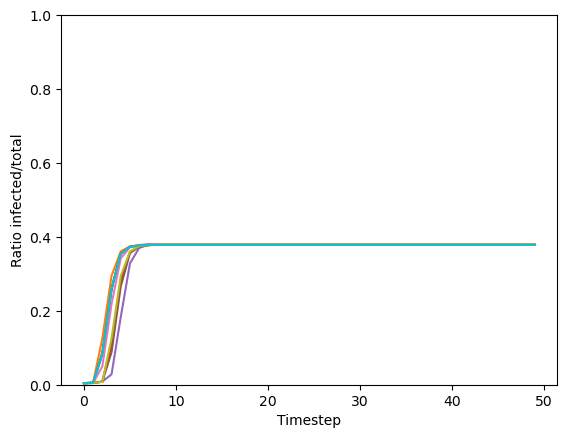

In [28]:
fig, ax = plt.subplots(1,1)
for k, v in res.items():
    ax.plot(v, label = k)
ax.set_xlabel("Timestep")
ax.set_ylabel("Ratio infected/total")
ax.set_ylim([0,1])
plt.show()

Running TSI with patients=2
Running TSI with patients=5
Running TSI with patients=10
Running TSI with patients=15
Running TSI with patients=20


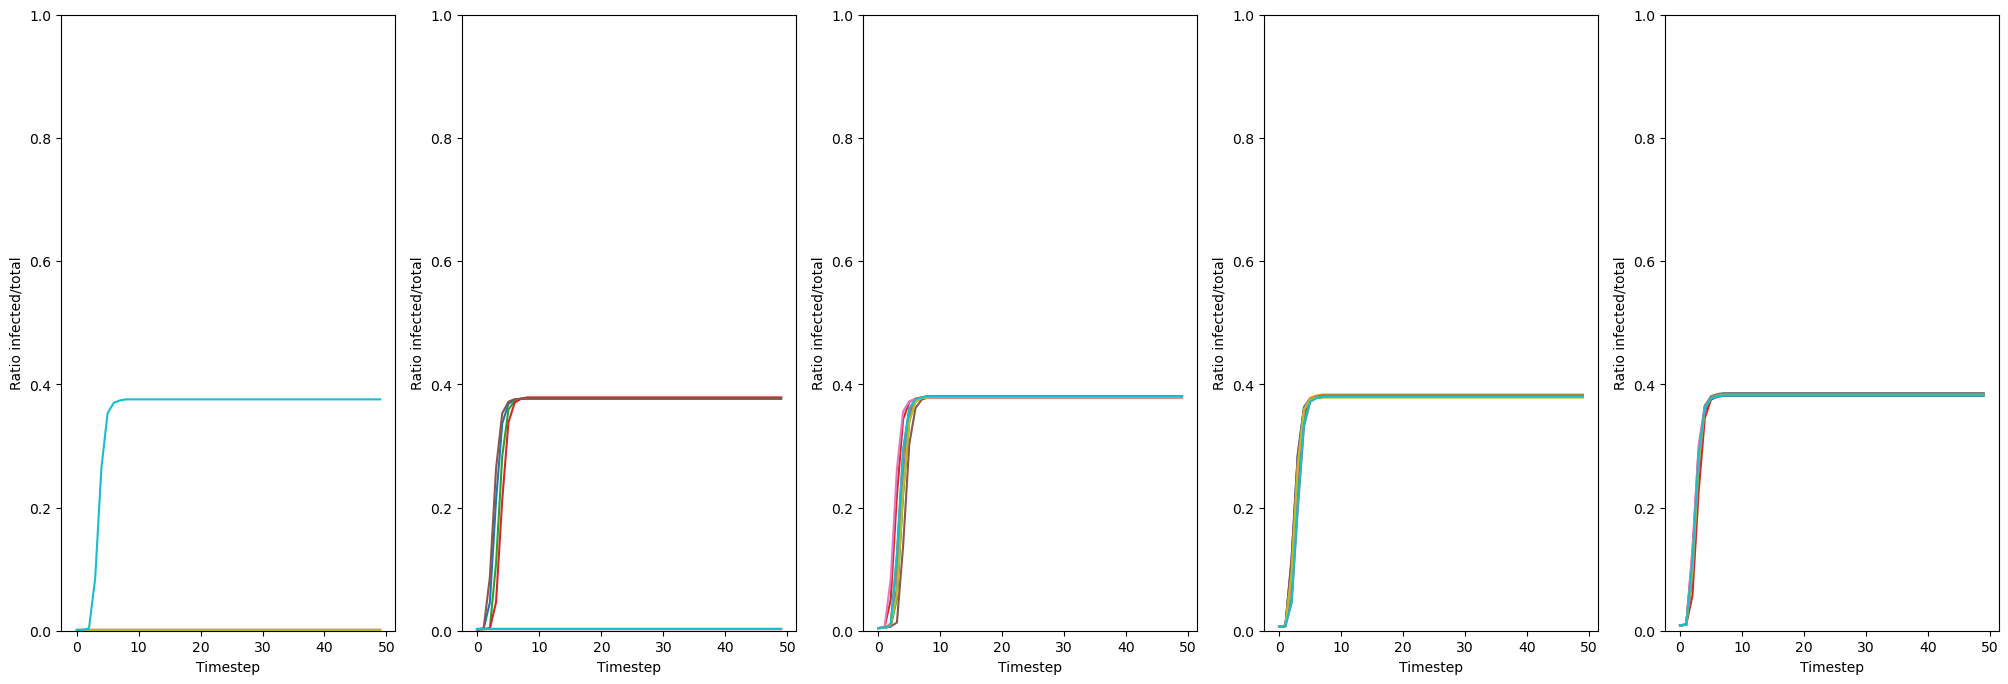

In [43]:
fig, axs = plt.subplots(1,5, figsize = (25,8))

for i, p in enumerate([2,5,10,15,20]):
    
    res, _ = run_TSI(patients=p, seed=p)

    ax = axs[i]
    for k, v in res.items():
        ax.plot(v, label = k)
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Ratio infected/total")
    ax.set_ylim([0,1])

plt.show()

<BarContainer object of 748 artists>

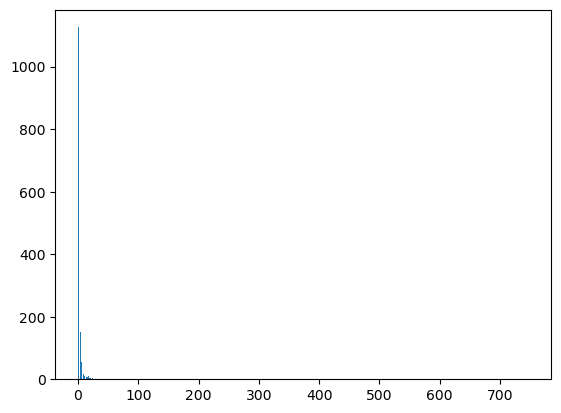

In [24]:
h = nx.degree_histogram(G_orig)
plt.bar([i for i in range(len(h))], h)

In [40]:
count = 0
for node in G_orig.nodes:
    if nx.degree(G_orig, node) > 1:
        count += 1
count/len(G_orig.nodes)

0.5194195475885617